# Overview

The primary goal of this project is to predict the number of dengue cases in Yogyakarta, Indonesia, using machine learning methods. Dengue fever is an important public health concern in tropical and subtropical regions; accurate forecasting can help in timely intervention and resource allocation. 


This project leverages historical data on dengue cases, rainfall, and relative humidity to build predictive models. By incorporating lagged features of these variables, I aim to capture the temporal dependencies and interactions that influence the incidence of dengue. Machine learning techniques, such as Long Short-Term Memory (LSTM) networks, target to effectively model these complex relationships. Hyperparameter optimization through Bayesian methods ensures that the model is fine-tuned for the best performance. This may be in its early stages, but I hope this project can help public health officials in mitigating the impact of dengue outbreaks in Yogyakarta or anywhere else in the world.

# DATASET


Data for dengue cases, rainfall (mm), and relative humidity (%) in Yogyakarta, Indonesia are sourced from  
[[1]](https://github.com/alramadona/yews4denv). The temporal resolution is monthly. The year range is from 2001 to 2013.

## 1. Import necessary libraries

The libraries that I will be using include (but not limited to) `polars`, `xlsx2csv` (to aid in loading xlsx files), `tensorflow`, `scikit-optimize` (for Bayesian optimization), `scikit-learn`.

In [101]:
!pip install xlsx2csv
!pip install scikit-optimize
!pip install scikeras


import polars as pl
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import mean_squared_error, r2_score



Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


## 2. Load the dataset and inspect

Note that the temperature readings were skipped. I will consider including them in the next sets of analyses. `polars` library was used to load the xlsx file.

In [13]:
# Load the Excel file
file_path = 'dengue_jogja/dataset_total-yogyakarta-indonesia-dengue-2001-2013-monthly.xlsx'
df = pl.read_excel(file_path)

# Display the first few rows of the dataframe
df.head()

,dengue,year,month,rain,temp,hum,time,denguel0,denguel1,denguel2,denguel3,denguel4,denguel5,denguel6,denguel7,denguel8,denguel9,denguel10,denguel11,denguel12,denguel13,denguel14,denguel15,denguel16,denguel17,denguel18,denguel19,denguel20,denguel21,denguel22,denguel23,denguel24,denguel25,denguel26,denguel27,denguel28,…,irBl24,irBl25,irBl26,irBl27,irBl28,irBl29,irBl30,irBl31,irBl32,irBl33,irBl34,irBl35,irBl36,irBl37,irBl38,irBl39,irBl40,irBl41,irBl42,irBl43,irBl44,irBl45,irBl46,irBl47,irBl48,irBl49,irBl50,irBl51,irBl52,irBl53,irBl54,irBl55,irBl56,irBl57,irBl58,irBl59,irBl60
i64,i64,i64,i64,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
1,48,2001,1,"""493""","""25.4""","""86""",1,48,"""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""",…,"""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A"""
2,47,2001,2,"""304""","""26""","""84""",2,47,"""48""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""",…,"""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A"""
3,47,2001,3,"""466""","""26.1""","""86""",3,47,"""47""","""48""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""",…,"""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A"""
4,63,2001,4,"""335""","""26.9""","""83""",4,63,"""47""","""47""","""48""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""",…,"""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A""","""#N/A"""
5,142,2001,5,"""46""","""27.2""","""79""",5,142,"""63""","""47""","""47""","""48"

Note that there are `#N/A` in some of the rows. These entries will be filtered out. Furthermore, `rain` (rainfall) and `hum` (humidity) will be casted to floats. Finally, `year` and `month` will be combined into a string named `year_month`.

In [106]:
# Filter rows in 'rain' column that start with '#'
df_filtered = df.filter(~pl.col('rain').str.starts_with('#'))

# Further filter rows where 'temp' and 'hum' columns do not start with '#'
df_filtered = df_filtered.filter(~df_filtered['hum'].str.starts_with('#'))



# Cast 'rain' and 'hum' columns to floats
df_filtered = df_filtered.with_columns([
    pl.col('rain').cast(pl.Float64),
    # pl.col('temp').cast(pl.Float64),
    pl.col('hum').cast(pl.Float64)
])




# Combine 'year' and 'month' columns to create 'year_month' column in the format YYYY-MM
df_filtered = df_filtered.with_columns([
    (pl.col('year').cast(pl.Utf8) + '-' + pl.col('month').cast(pl.Utf8).str.zfill(2)).alias('year_month')
])




df_filtered = df_filtered.select(['year_month', 'dengue', 'rain', 'hum'])


# Display the first few rows of the dataframe to verify the changes
df_filtered.head()

year_month,dengue,rain,hum
str,i64,f64,f64
"""2001-01""",48,493.0,86.0
"""2001-02""",47,304.0,84.0
"""2001-03""",47,466.0,86.0
"""2001-04""",63,335.0,83.0
"""2001-05""",142,46.0,79.0


Let's plot the dengue cases, rainfall, and humidity in Jogja (as the locals call it!).

<Figure size 640x480 with 0 Axes>

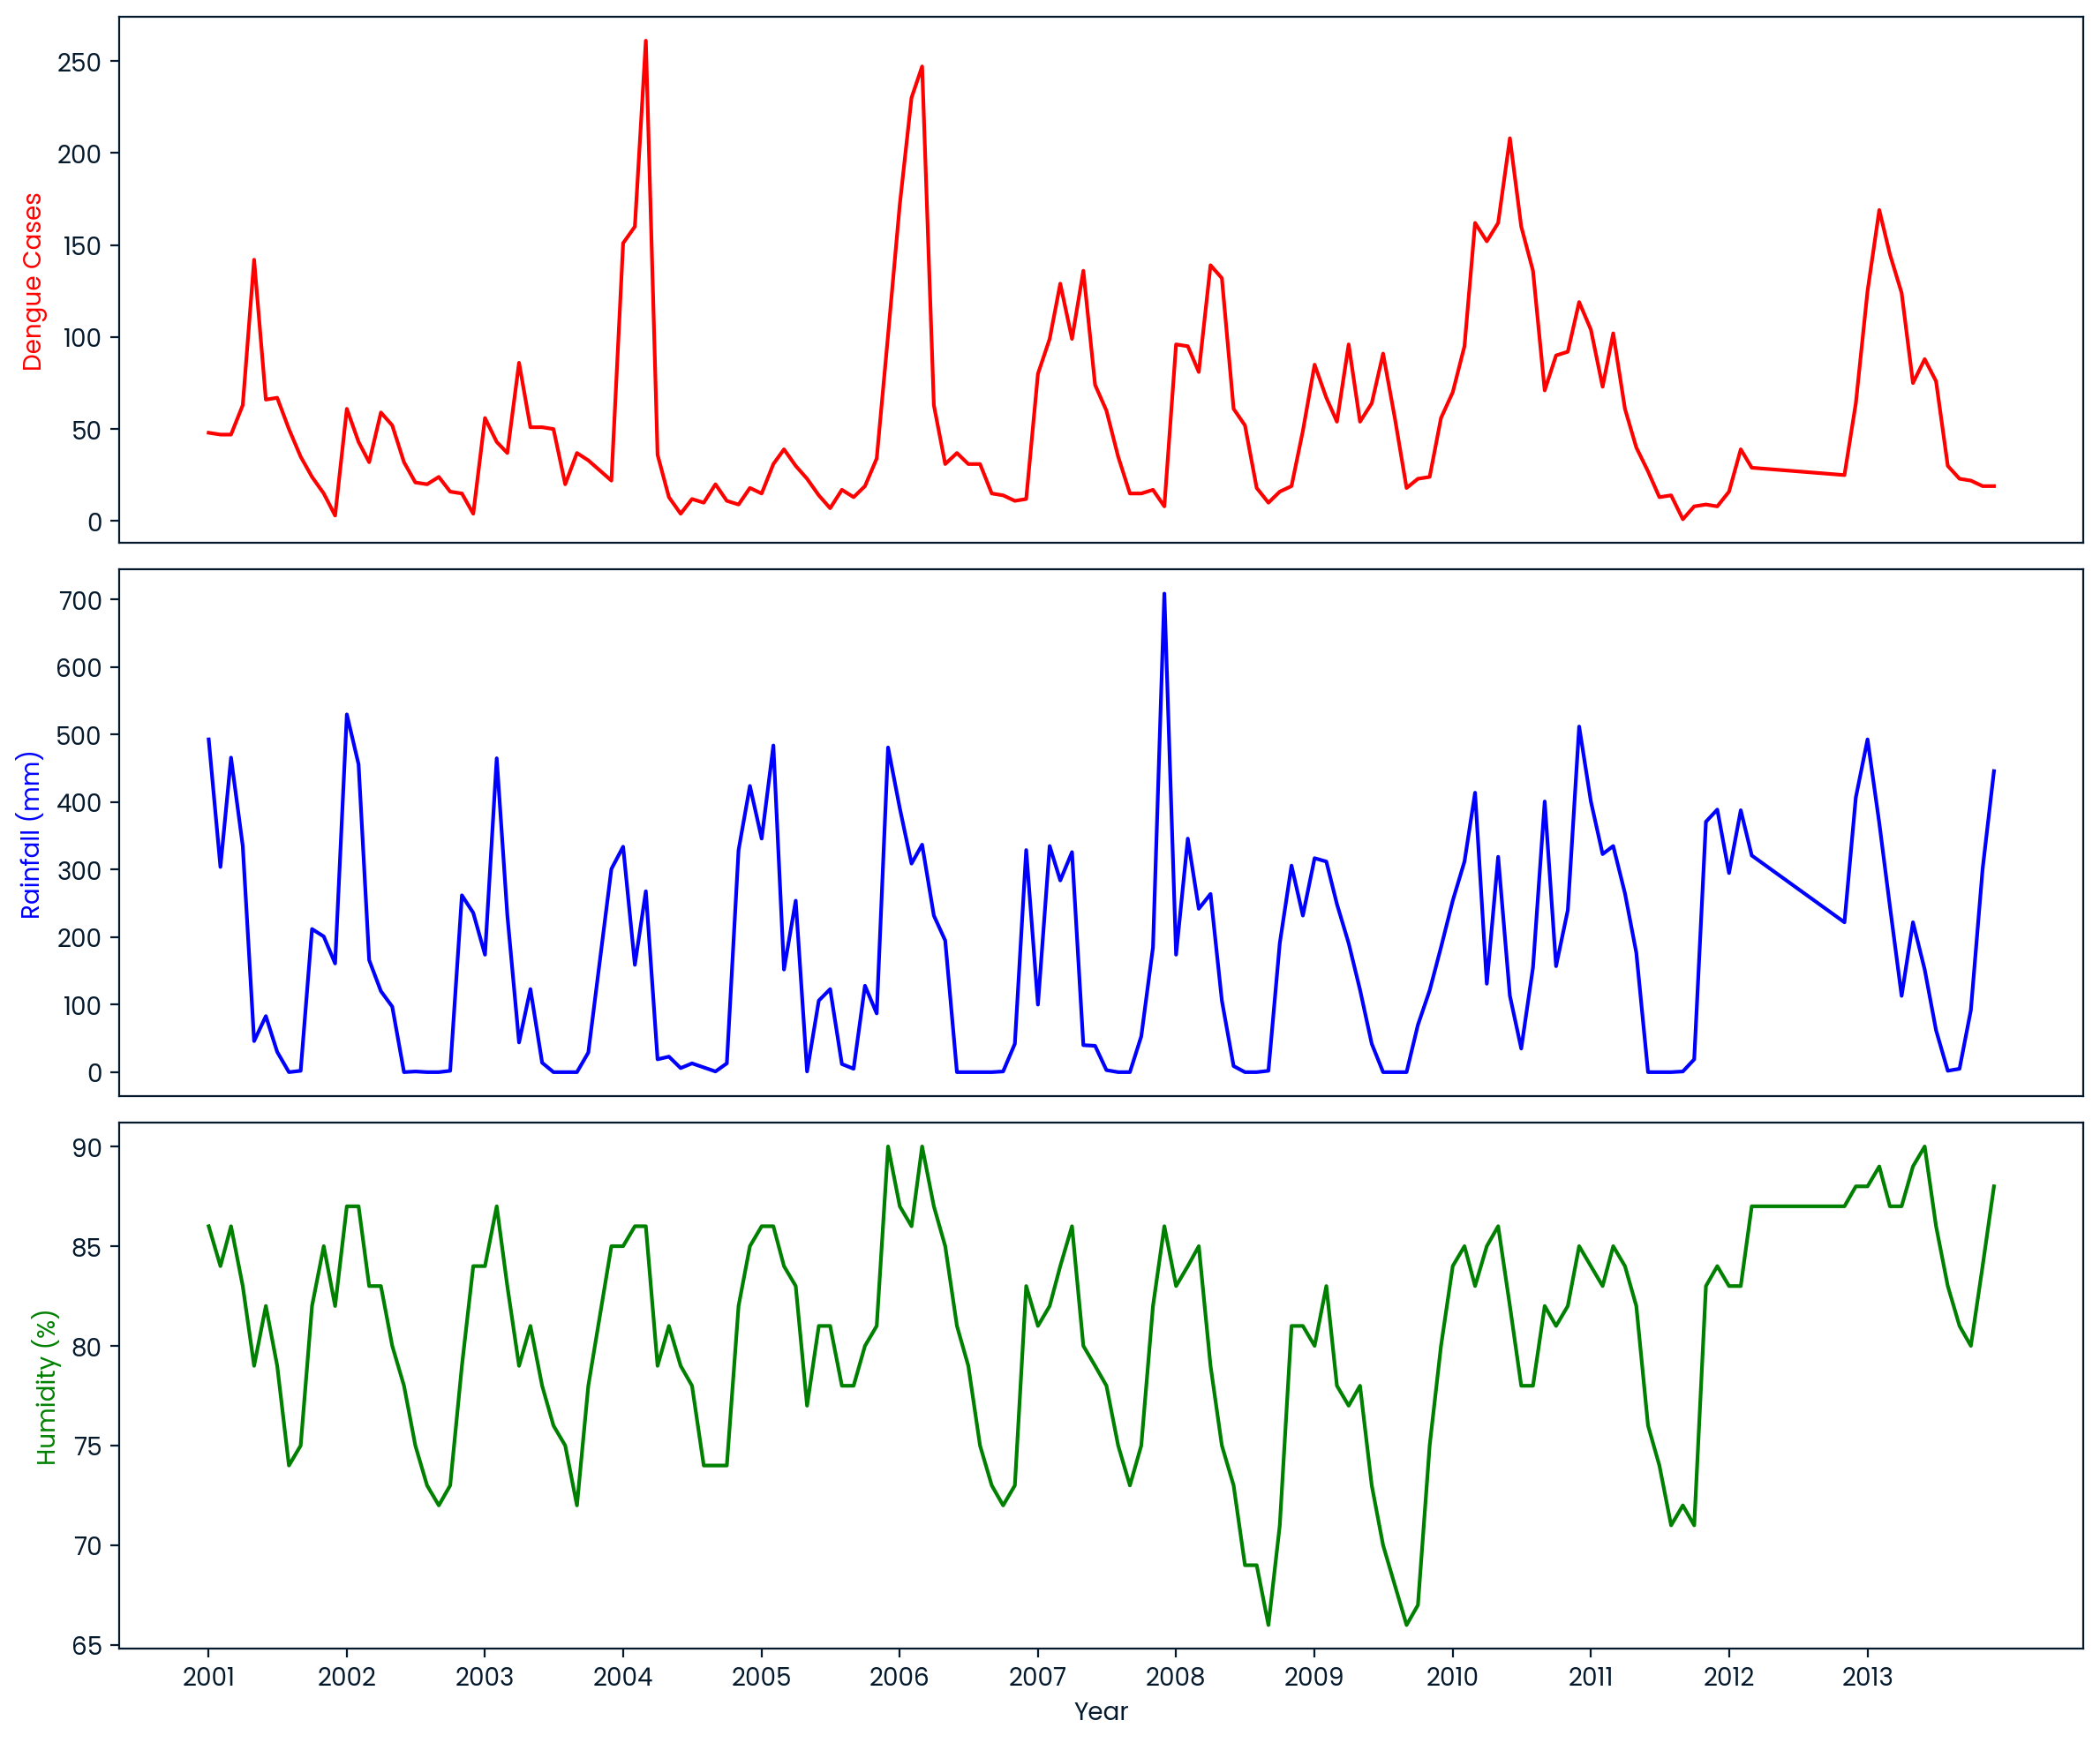

In [113]:
plt.clf()

# Convert 'year_month' to datetime for better plotting
df_filtered = df_filtered.with_columns([
    pl.col('year_month').str.strptime(pl.Date, format='%Y-%m')
])


# Create a 3x1 subplot
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot dengue cases
axs[0].plot(df_filtered['year_month'], df_filtered['dengue'], color='red')
axs[0].set_ylabel('Dengue Cases', color='red')
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot rainfall
axs[1].plot(df_filtered['year_month'], df_filtered['rain'], color='blue')
axs[1].set_ylabel('Rainfall (mm)', color='blue')
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plot humidity
axs[2].plot(df_filtered['year_month'], df_filtered['hum'], color='green')
axs[2].set_ylabel('Humidity (%)', color='green')
axs[2].set_xlabel('Year')
axs[2].set_xticks(pd.date_range(start='2001-01', end='2013-12', freq='YS'))
axs[2].set_xticklabels(range(2001, 2014))

plt.tight_layout()
plt.show()

In [18]:
# For forecasting dengue cases using lagged features, a suitable machine learning model would be a time series regression model. One effective approach is to use an AutoRegressive Integrated Moving Average with Exogenous variables (ARIMAX) model or a Vector Autoregression (VAR) model. However, for simplicity and flexibility, you can also use machine learning models like Random Forest Regressor or XGBoost Regressor with lagged features.

# Here's a step-by-step approach to prepare your data and build a model using lagged features:

# Create Lagged Features: Generate lagged versions of dengue, rain, and hum.
# Train-Test Split: Split the data into training and testing sets.
# Model Training: Train a regression model using the lagged features.
# Prediction: Use the trained model to predict future dengue cases.

## 3. Perform correlation analyses


To understand the temporal dependencies in the data, I calculated the autocorrelation of dengue cases and the cross-correlations between dengue cases and other variables like rain and humidity. Since the temporal resolution is in months, 6-month windows were only considered.


<Figure size 640x480 with 0 Axes>

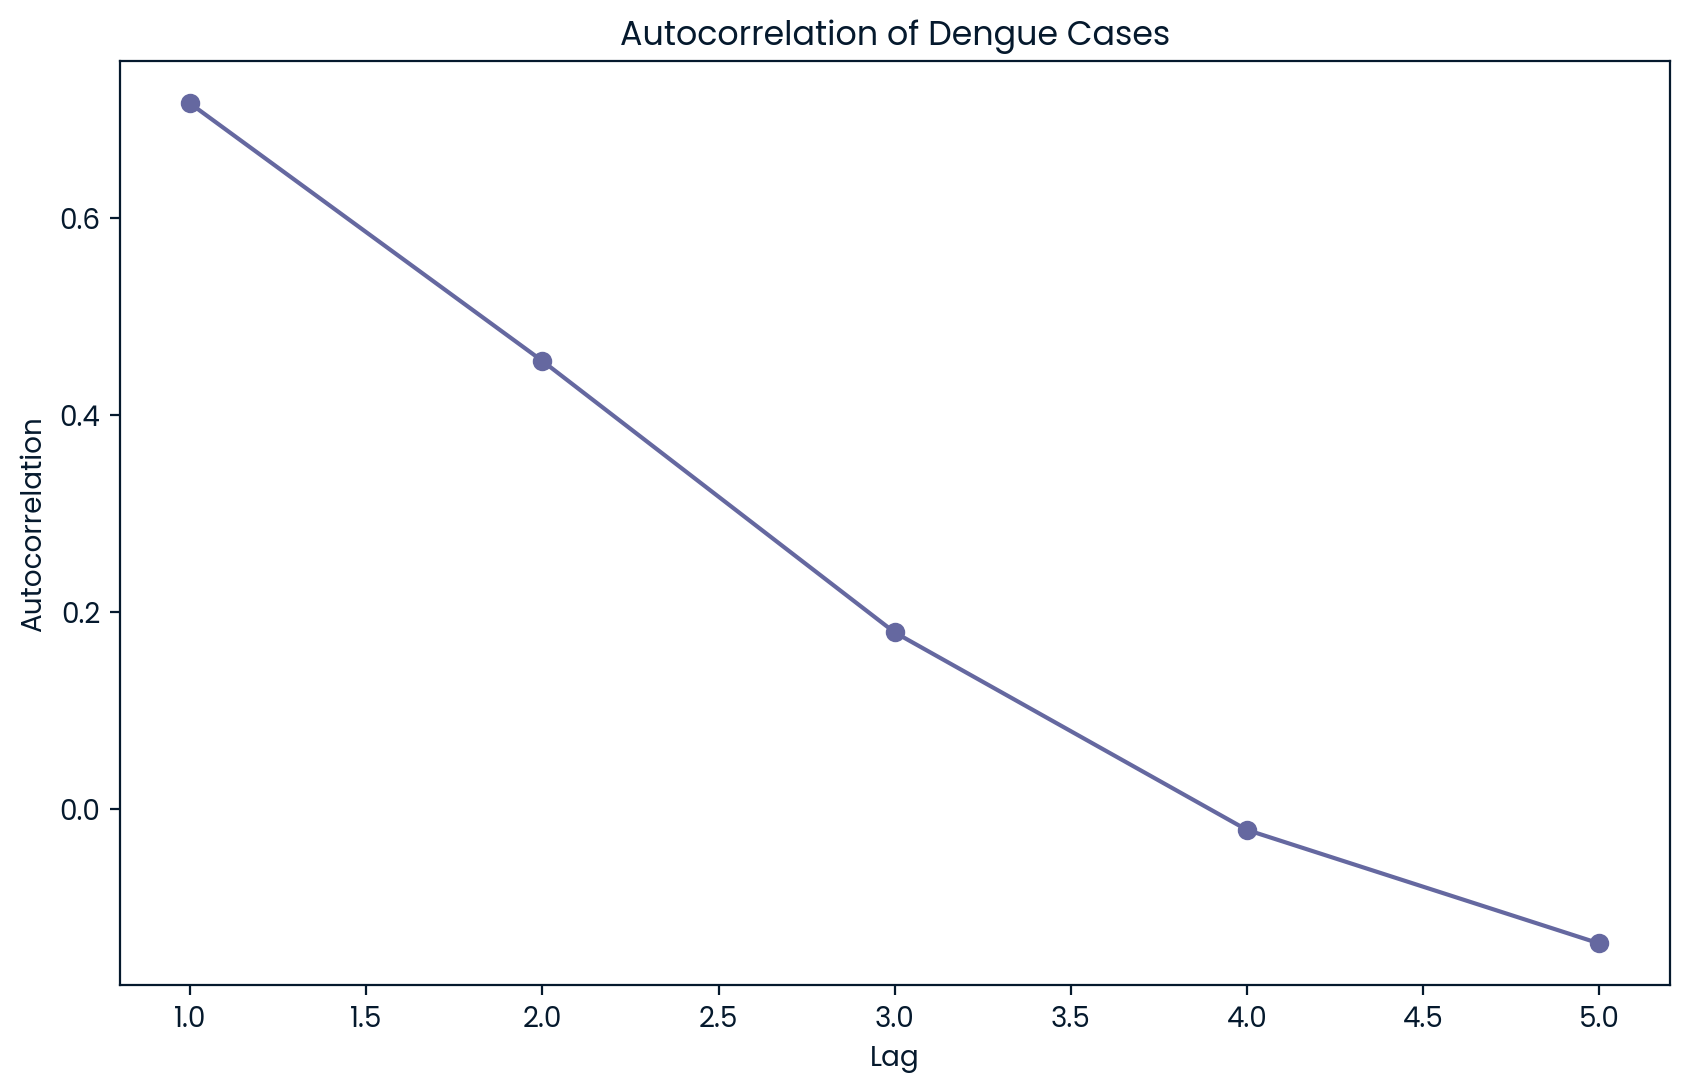

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

plt.clf()
maxlag = 6

# Assuming df_filtered is already loaded as a Polars DataFrame
# Calculate autocorrelation for dengue
dengue_series = df_filtered['dengue'].to_numpy()
autocorr = [np.corrcoef(dengue_series[:-lag], dengue_series[lag:])[0, 1] for lag in range(1, maxlag)]

# Find the peak in autocorrelation
peaks, _ = find_peaks(autocorr)

# Check if peaks are found before attempting to find the optimal lag
if peaks.size > 0:
    optimal_lag_dengue = peaks[np.argmax([autocorr[peak] for peak in peaks])] + 1
else:
    optimal_lag_dengue = None

# Plot autocorrelation
plt.figure(figsize=(10, 6))
plt.plot(range(1, maxlag), autocorr, marker='o')
plt.title('Autocorrelation of Dengue Cases')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

if optimal_lag_dengue is not None:
    plt.axvline(optimal_lag_dengue, color='r', linestyle='--', label=f'Optimal Lag: {optimal_lag_dengue}')
    plt.legend()

plt.show()

optimal_lag_dengue

While there was no "peak" observed over the 6-month window (see figure above), I safely used **lag=1 month** to be the optimal lag for dengue cases.

<Figure size 640x480 with 0 Axes>

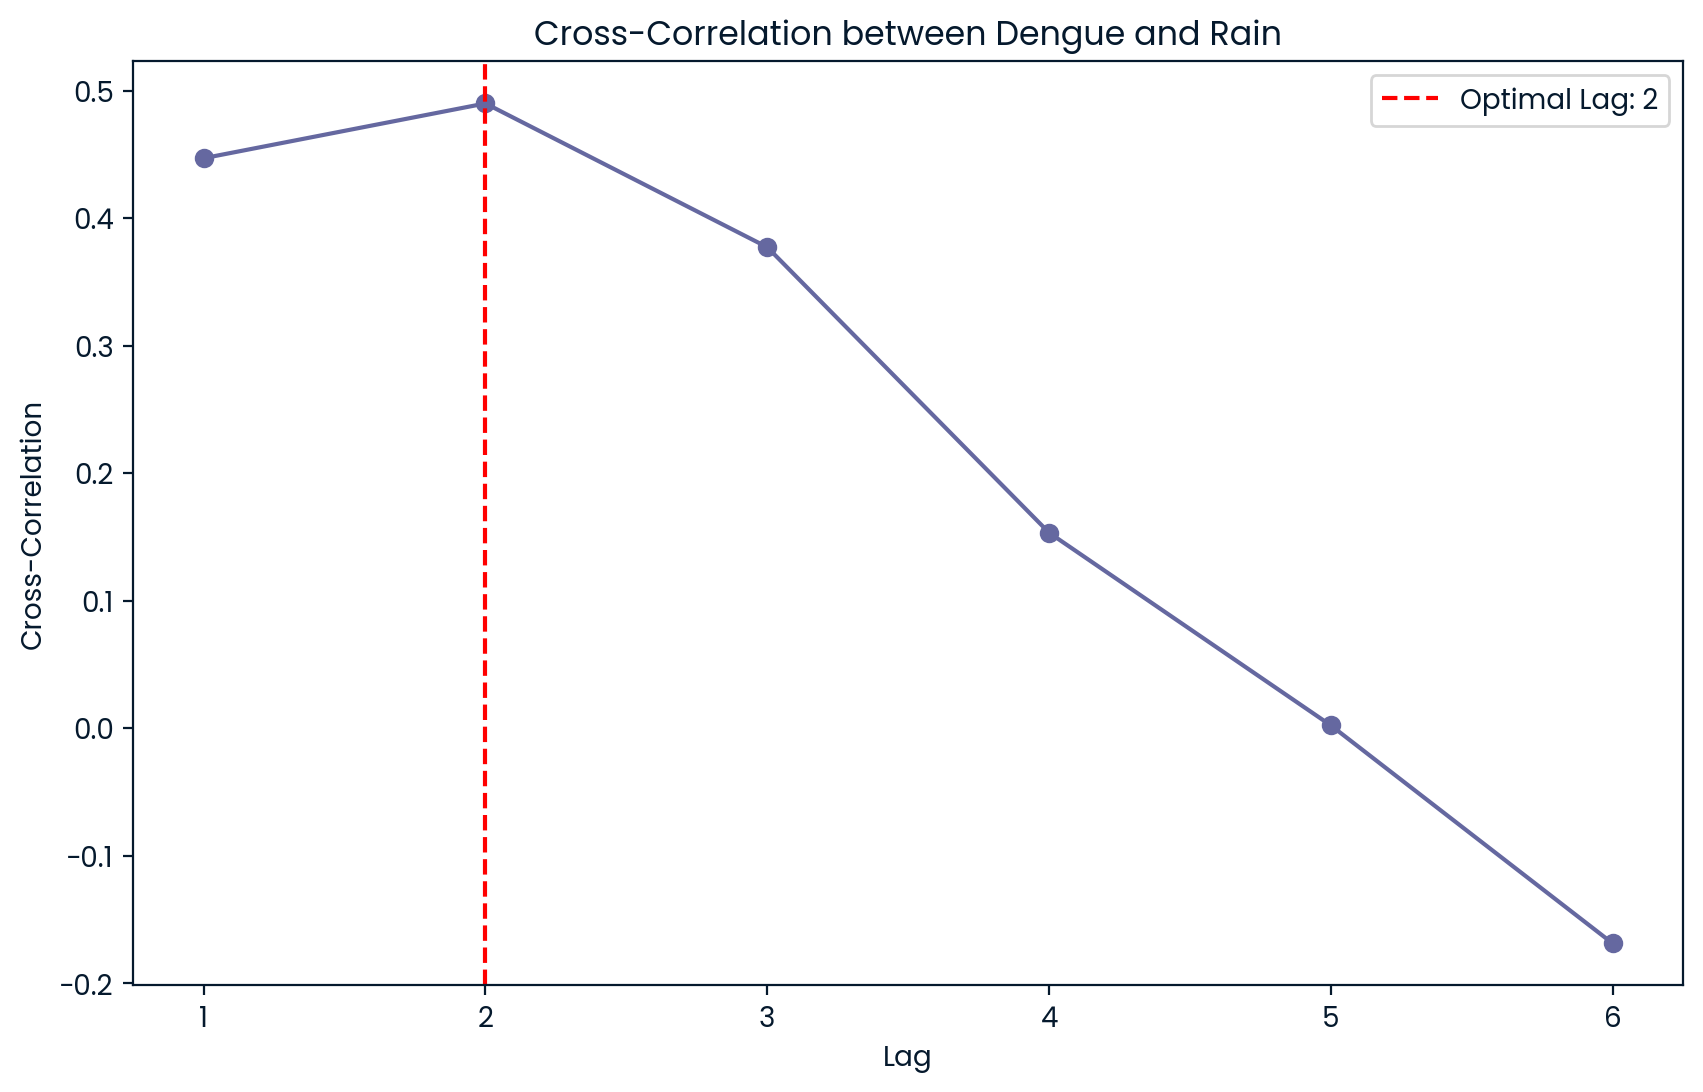

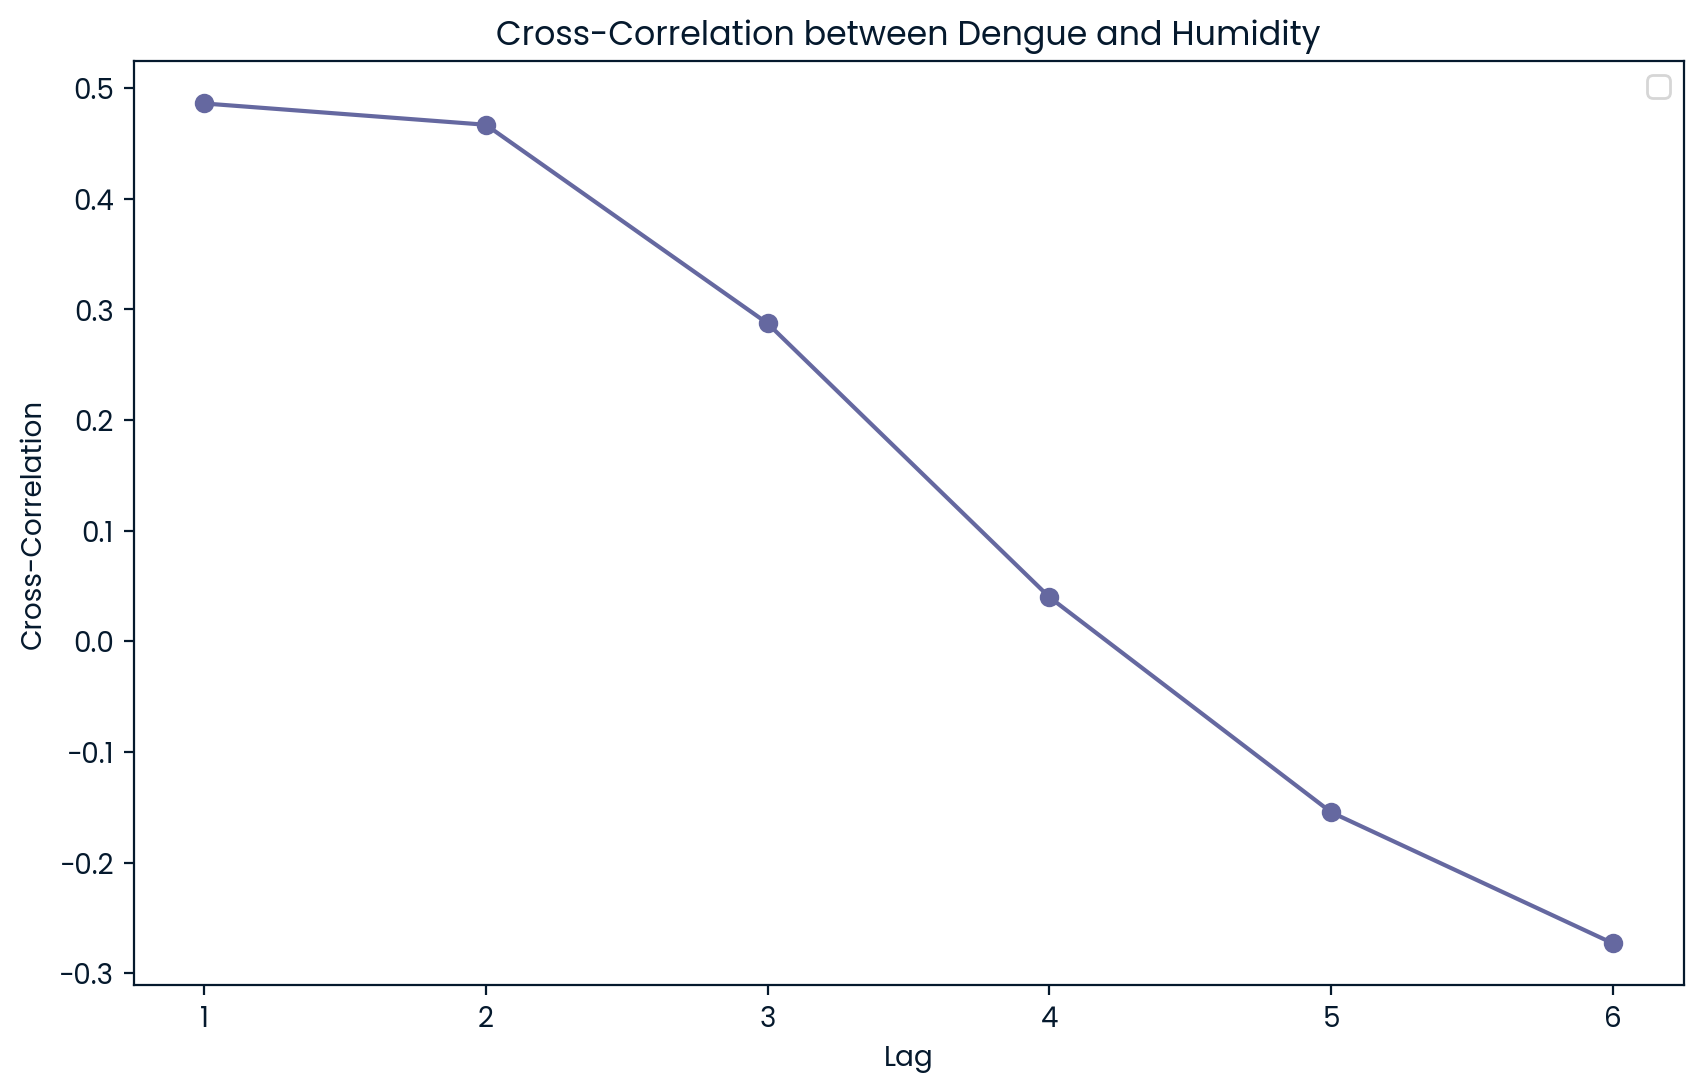

(2, None)

In [119]:
# Function to calculate cross-correlation
def cross_correlation(series1, series2, max_lag):
    return [np.corrcoef(series1[:-lag], series2[lag:])[0, 1] for lag in range(1, max_lag + 1)]

maxlag = 6

# Convert rain and hum to numpy arrays
rain_series = df_filtered['rain'].to_numpy()
hum_series = df_filtered['hum'].to_numpy()
dengue_series = df_filtered['dengue'].to_numpy()  # Assuming dengue_series is also part of df_filtered

# Calculate cross-correlation for dengue-rain
crosscorr_rain = cross_correlation(rain_series, dengue_series, maxlag)
peaks_rain, _ = find_peaks(crosscorr_rain)
if peaks_rain.size > 0:
    optimal_lag_rain = peaks_rain[np.argmax([crosscorr_rain[peak] for peak in peaks_rain])] + 1
else:
    optimal_lag_rain = None

# Calculate cross-correlation for dengue-hum
crosscorr_hum = cross_correlation(hum_series, dengue_series, maxlag)
peaks_hum, _ = find_peaks(crosscorr_hum)
if peaks_hum.size > 0:
    optimal_lag_hum = peaks_hum[np.argmax([crosscorr_hum[peak] for peak in peaks_hum])] + 1
else:
    optimal_lag_hum = None

plt.clf()

# Plot cross-correlation for rain
plt.figure(figsize=(10, 6))
plt.plot(range(1, maxlag+1), crosscorr_rain, marker='o')
plt.title('Cross-Correlation between Dengue and Rain')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
if optimal_lag_rain is not None:
    plt.axvline(optimal_lag_rain, color='r', linestyle='--', label=f'Optimal Lag: {optimal_lag_rain}')
plt.legend()
plt.show()

# Plot cross-correlation for hum
plt.figure(figsize=(10, 6))
plt.plot(range(1, maxlag+1), crosscorr_hum, marker='o')
plt.title('Cross-Correlation between Dengue and Humidity')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
if optimal_lag_hum is not None:
    plt.axvline(optimal_lag_hum, color='r', linestyle='--', label=f'Optimal Lag: {optimal_lag_hum}')
plt.legend()
plt.show()

optimal_lag_rain, optimal_lag_hum

Results show that **lag=2 months** was the optimal lag for cross-correlation between dengue cases and rainfall. While there was no "peak" observed for the cross-correlation between dengue cases and humidity, I used **lag=1 month** as the optimal lag.

## 3. Data preprocessing


Based on the autocorrelation and cross-correlation analysis, optimal lags for dengue cases, rain, and humidity were determined. The next step was to create a lagged DataFrame to include these features.




In [120]:
# # Optimal lags
optimal_lag_dengue = 1
optimal_lag_hum = 1

# Create lagged features
df_lagged = df_filtered.with_columns([
    pl.col('dengue').shift(optimal_lag_dengue).alias(f'dengue_lag_{optimal_lag_dengue}'),
    pl.col('rain').shift(optimal_lag_rain).alias(f'rain_lag_{optimal_lag_rain}'),
    pl.col('hum').shift(optimal_lag_hum).alias(f'hum_lag_{optimal_lag_hum}')
])

# Drop rows with missing values
df_lagged = df_lagged.drop_nulls()

df_lagged.head()

year_month,dengue,rain,hum,dengue_lag_1,rain_lag_2,hum_lag_1
date,i64,f64,f64,i64,f64,f64
2001-03-01,47,466.0,86.0,47,493.0,84.0
2001-04-01,63,335.0,83.0,47,304.0,86.0
2001-05-01,142,46.0,79.0,63,466.0,83.0
2001-06-01,66,83.0,82.0,142,335.0,79.0
2001-07-01,67,30.0,79.0,66,46.0,82.0


I split the data into training and testing sets to evaluate the model's performance. I then used a `sklearn`-based pipeline to standardize the training and testing data.


In [121]:
# Extract features and target
feature_columns = [f'dengue_lag_{optimal_lag_dengue}', f'rain_lag_{optimal_lag_rain}', f'hum_lag_{optimal_lag_hum}']
X = df_lagged.select(feature_columns).to_numpy()
y = df_lagged['dengue'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a pipeline to standardize the data
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Fit and transform the training data
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

# Reshape data for LSTM (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

## 4. Modeling


I used a Long Short-Term Memory (LSTM) model via `tensorflow.keras` and then performed Bayesian optimization via `scikit-optimize` to find the best hyperparameters.



LSTMs are recurrent neural network (RNN) that are well-suited for time series forecasting due to their ability to capture temporal dependencies. The LSTM model used in this project comprises the following components:

**LSTM Layer**: This layer has a specified number of units (neurons) that are optimized using Bayesian optimization. The LSTM layer is responsible for capturing the temporal dependencies in the data.  <br>
**Dropout Layer**: This layer is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time. The dropout rate is also optimized using Bayesian optimization. <br>
**Dense Layer**: This is the output layer with a single neuron, as we are predicting a single value (dengue cases). <br>
**Optimizer**: The Adam optimizer is used with a learning rate that is optimized using Bayesian optimization. <br>
**Loss Function**: The mean squared error (MSE) loss function is used to measure the model's performance. <br>





### Hyperparameter Optimization
Bayesian optimization is used to find the optimal hyperparameters for the LSTM model. The hyperparameters optimized included:

**Number of Units**: The number of neurons in the LSTM layer. <br>
**Dropout Rate**: The fraction of input units to drop during training. <br>
**Learning Rate**: The learning rate for the Adam optimizer. <br>


In [90]:
# Define the LSTM model
def create_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the model using KerasRegressor
model = KerasRegressor(model=create_model, epochs=50, batch_size=32, verbose=0)

# Define the parameter space for Bayesian optimization
param_space = {
    'model__units': Integer(10, 100),
    'model__dropout_rate': Real(0.1, 0.5),
    'model__learning_rate': Real(0.0001, 0.01, prior='log-uniform')
}

# Perform Bayesian optimization
opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=32,
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Fit the model
opt.fit(X_train_scaled, y_train)

# Best parameters
print(f'Best Parameters: {opt.best_params_}')

2024-11-30 10:10:42.616379: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 10:10:42.616770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 10:10:42.618132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 10:10:47.727595: I tensorflow/core/platform/cpu_featu

Best Parameters: OrderedDict([('model__dropout_rate', 0.10456025726153483), ('model__learning_rate', 0.009886807089779164), ('model__units', 100)])


## 5. Evaluate model performance

The model performance was evaluated using the following metrics:

**Mean Squared Error (MSE)**: Measures the average squared difference between the actual and predicted values. <br>
**R-squared (R^2)**: Indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. <br>


I also created a scatter plot to visualize the actual versus predicted values, along with a best-fit line and the R^2 value.



Mean Squared Error: 940.5737975344938
R^2 Score: 0.6283120568527671


<Figure size 640x480 with 0 Axes>

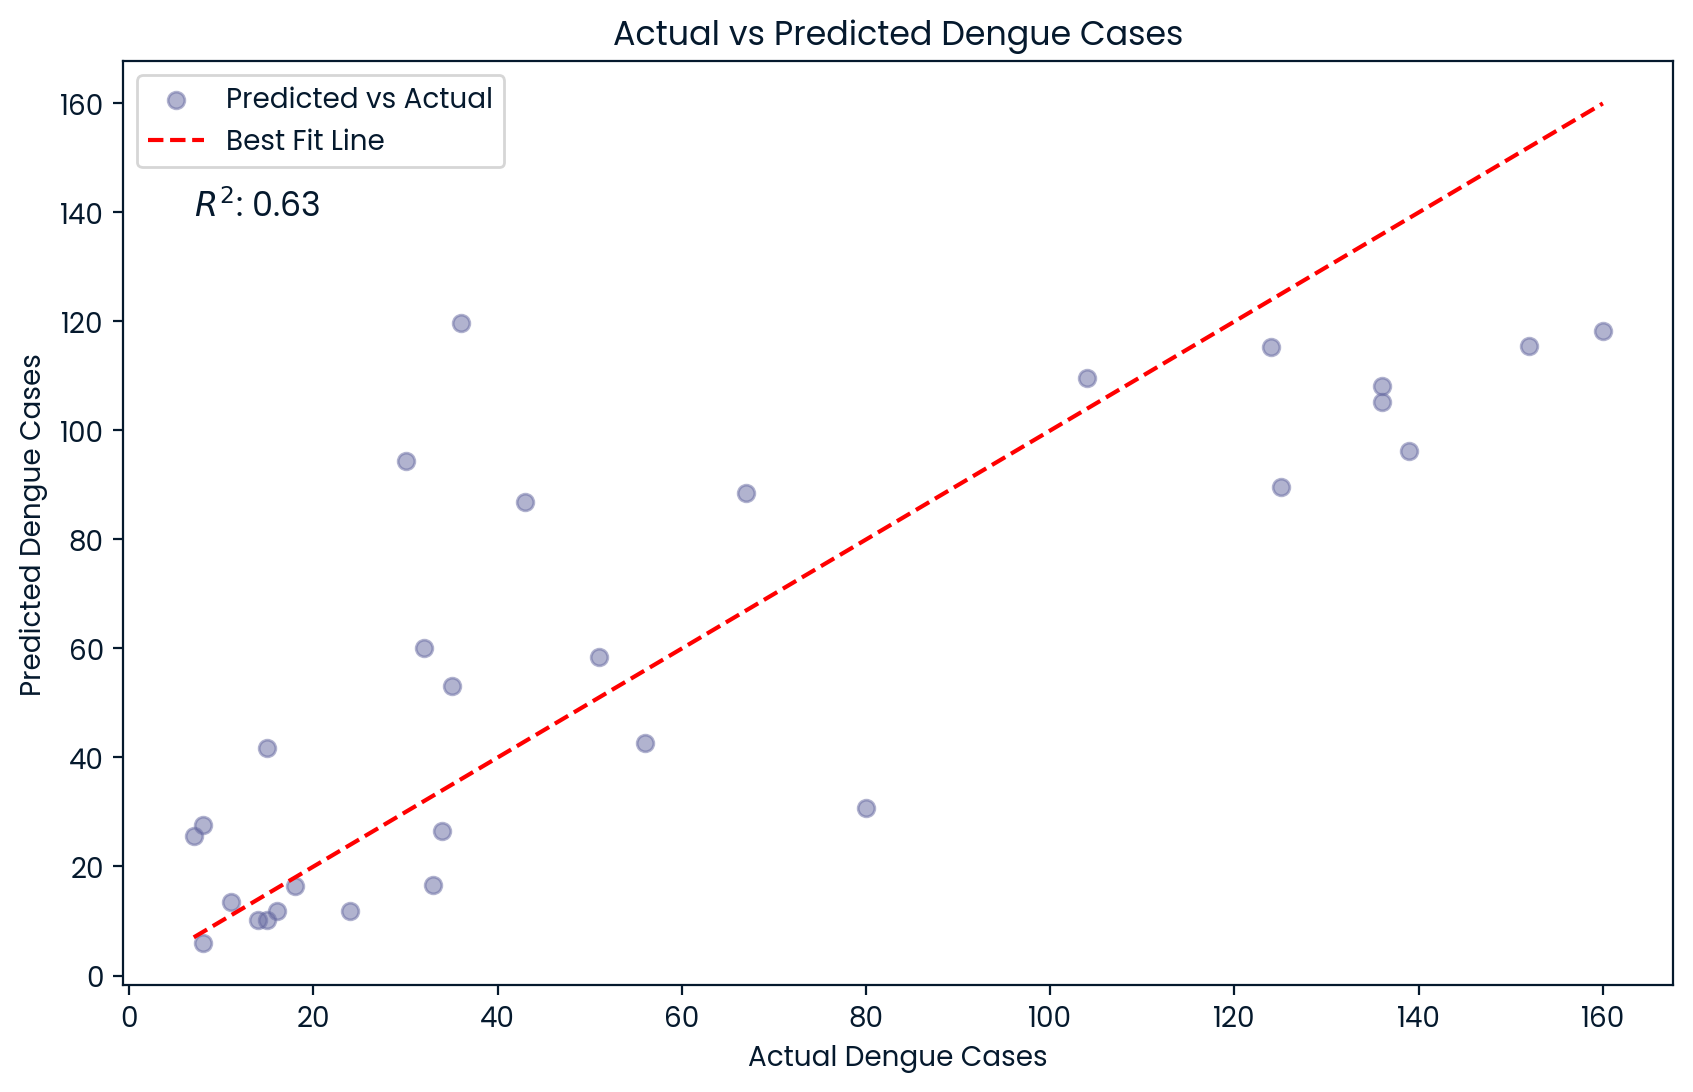

In [97]:
# Make predictions
y_pred = opt.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

plt.clf()

# Scatter plot of actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Best Fit Line')
plt.title('Actual vs Predicted Dengue Cases')
plt.xlabel('Actual Dengue Cases')
plt.ylabel('Predicted Dengue Cases')
plt.legend(loc='best')

# Add R^2 value as text
plt.text(min(y_test), 0.9*max(y_test), f'$R^2$: {r2:.2f}', fontsize=12, verticalalignment='top')

plt.show()

## 6. Perform next-month predictions

The dengue cases for "next month" were forecasted via the last training data points.

In [125]:
# Extract the Last Training Data Points
last_lagged_features = df_lagged.select(feature_columns).to_numpy()[-1].reshape(1, -1)

# Standardize the Features
last_lagged_features_scaled = pipeline.transform(last_lagged_features)

# Reshape the Data
last_lagged_features_scaled = last_lagged_features_scaled.reshape((last_lagged_features_scaled.shape[0], 1, last_lagged_features_scaled.shape[1]))

# Make Predictions
next_month_prediction = opt.predict(last_lagged_features_scaled)
print(f'Predicted Dengue Cases for Next Month: {int(next_month_prediction[0])}')

Predicted Dengue Cases for Next Month: 40


As a recap, I was able to forecast forecasting dengue cases next month using an LSTM model with hyperparameters optimized through Bayesian optimization. To build the model, I performed autocorrelation and cross-correlation analyses, then created lagged features, standardized the data, defined and optimized the LSTM model, and evaluated the model's performance.


In the future, I plan to explore other machine learning methods as well as established statistical models like ARIMA / ARIMAX / SARIMA. Finally, I also plan to include the effects of other climatological variables like temperature and wind speed, as well as infuse demographic features.


If you have questions, send them over at jprmaulion(at)gmail(dot)com.